In [30]:
import numpy as np
import pandas as pd
import os
import pathlib as Path
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import requests
from police_api import PoliceAPI

api = PoliceAPI()

px.set_mapbox_access_token("pk.eyJ1IjoibXJhZmlwaCIsImEiOiJjbGMzdWZ0MTIwNmt5M3B0ODNnbzF1a3d2In0.7VgLitY9OXxhPSxlxJglfQ")

In [31]:
df_out_2023_03 = pd.read_csv(r'.\\Datasets\\2022-2023\\2023-03\\2023-03-metropolitan-outcomes.csv')
df_ss_2023_03 = pd.read_csv(r'.\\Datasets\\2022-2023\\2023-03\\2023-03-metropolitan-stop-and-search.csv')
df_street_2011_02 = pd.read_csv(r'.\\Datasets\\2010-2017\\2011-02\\2011-02-metropolitan-street.csv')
df_street_2011_02[df_street_2011_02['Crime type'] == 'Burglary'].head()


,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
25,NaN,2011-02,Metropolitan Police Service,Metropolitan Police Service,0.128330,51.584559,On or near Nash Road,E01000028,Barking and Dagenham 001B,Burglary,NaN,NaN
26,NaN,2011-02,Metropolitan Police Service,Metropolitan Police Service,0.126964,51.586508,On or near Rowan Way,E01000028,Barking and Dagenham 001B,Burglary,NaN,NaN
27,NaN,2011-02,Metropolitan Police Service,Metropolitan Police Service,0.129225,51.583922,On or near Gregory Road,E01000028,Barking and Dagenham 001B,Burglary,NaN,NaN
28,NaN,2011-02,Metropolitan Police Service,Metropolitan Police Service,0.131680,51.586432,On or near Newhouse Avenue,E01000028,Barking and Dagenham 001B,Burglary,NaN,NaN
38,NaN,2011-02,Metropolitan Police Service,Metropolitan Police Service,0.139479,51.579743,On or near Yew Tree Gardens,E01000029,Barking and Dagenham 001C,Burglary,NaN,NaN


In [32]:
def fast_scandir(dirname):
    subfolders= [f.path for f in os.scandir(dirname) if f.is_dir()]
    for dirname in list(subfolders):
        subfolders.extend(fast_scandir(dirname))
    return subfolders

subfolders = fast_scandir(r'./Datasets')

In [33]:
all_street_df = []
all_ss_df = []
all_outcome_df = []
for i in range(4, len(subfolders)):
    street_file_name =  [ file for file in os.listdir(subfolders[i]) if "street" in file]
    ss_file_name = [ file for file in os.listdir(subfolders[i]) if "search" in file]
    outcome_file_name = [ file for file in os.listdir(subfolders[i]) if "outcome" in file]
    if len(street_file_name) > 0:
        df = pd.read_csv(os.path.join(subfolders[i], street_file_name[0]))
        all_street_df.append(df)
    elif len(ss_file_name) > 0:
        df = pd.read_csv(os.path.join(subfolders[i], ss_file_name[0]))
        all_ss_df.append(df)
    if len(outcome_file_name) > 0:
        df = pd.read_csv(os.path.join(subfolders[i], outcome_file_name[0]))
        all_outcome_df.append(df)

In [34]:
street_all_years = pd.concat(all_street_df, ignore_index=True)
df_clean = street_all_years.drop(columns=['Context'])
df_clean['Month']= pd.to_datetime(df_clean['Month'])
df_clean['Year'] = df_clean['Month'].dt.year
df_clean = df_clean.rename(columns={'Month': 'Date'})
df_clean['Month'] = df_clean['Date'].dt.month
burglary_data = df_clean.loc[(df_clean['Crime type'] == 'Burglary') & (df_clean['LSOA name'].str.contains("Barnet"))]
burglary_data.head()


,Crime ID,Date,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Year,Month
2546,NaN,2011-03-01,Metropolitan Police Service,Metropolitan Police Service,-0.211600,51.657530,On or near Cecil Court,E01000249,Barnet 001B,Burglary,NaN,2011,3
2547,NaN,2011-03-01,Metropolitan Police Service,Metropolitan Police Service,-0.211600,51.657530,On or near Cecil Court,E01000249,Barnet 001B,Burglary,NaN,2011,3
2548,NaN,2011-03-01,Metropolitan Police Service,Metropolitan Police Service,-0.217135,51.653172,On or near Argyle Road,E01000249,Barnet 001B,Burglary,NaN,2011,3
2549,NaN,2011-03-01,Metropolitan Police Service,Metropolitan Police Service,-0.211600,51.657530,On or near Cecil Court,E01000249,Barnet 001B,Burglary,NaN,2011,3
2550,NaN,2011-03-01,Metropolitan Police Service,Metropolitan Police Service,-0.210451,51.657719,On or near Wentworth Road,E01000249,Barnet 001B,Burglary,NaN,2011,3


In [35]:
fig = ff.create_hexbin_mapbox(
            data_frame=burglary_data, lat="Latitude", lon="Longitude",
            opacity=1.0, labels={"color": "Point Count"},
            min_count=1, zoom=10, show_original_data=True
        )
fig.update_layout(margin=dict(b=0, t=0, l=0, r=0))
fig.show()

In [36]:
burglary_data = burglary_data.loc[(burglary_data['Year'] != 2020) | (burglary_data['Year'] != 2021)]
df_training = burglary_data.loc[(burglary_data['Year'] != 2022) | (burglary_data['Year'] != 2023)]
df_val = burglary_data.loc[(burglary_data['Year'] == 2022) | (burglary_data['Year'] == 2023)]
training_grouped = df_training.groupby(['Date']).count()
validation_grouped = df_val.groupby(['Date']).count()

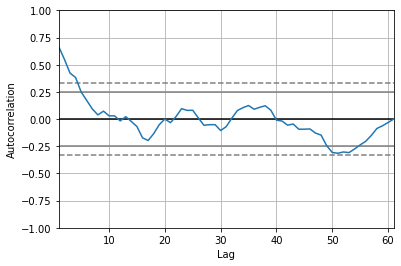

In [37]:
import matplotlib.pyplot as plt

s = training_grouped['Location']

# Creating Autocorrelation plot
x = pd.plotting.autocorrelation_plot(s)
 
# plotting the Curve
x.plot()
 
# Display
plt.show()

<AxesSubplot: xlabel='Date'>

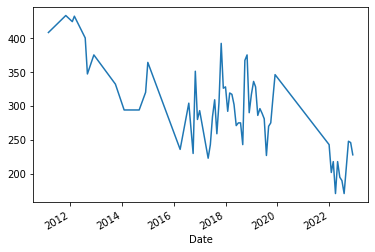

In [38]:
# Growth of burglaries over the years
s.plot()

p-value: 0.05899887311823958


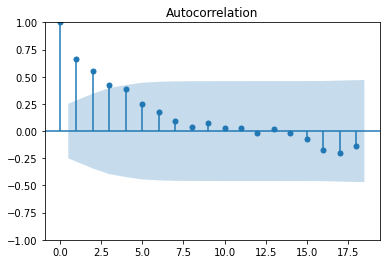

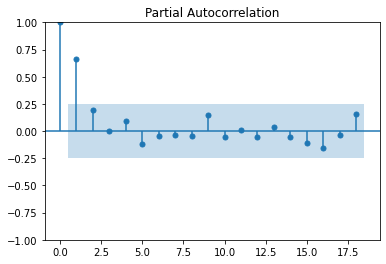

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# ADF test to see stationarity
adf_test = adfuller(training_grouped[['Location']])
# When p <= 0.05, then data is stationary
print(f'p-value: {adf_test[1]}')
# Compute autocorrelation
acf = plot_acf(training_grouped[['Location']])

# Compute partial autocorrelation function
pacf = plot_pacf(training_grouped[['Location']])


<AxesSubplot: xlabel='Date'>

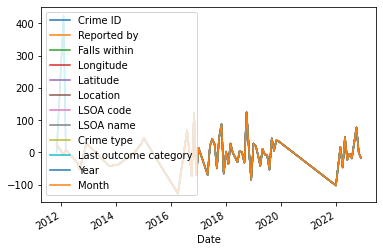

In [78]:
df_train_diff = training_grouped.diff().dropna()
df_train_diff.plot()

p-value: 2.0639296346912603e-09


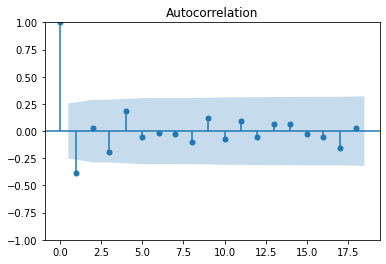

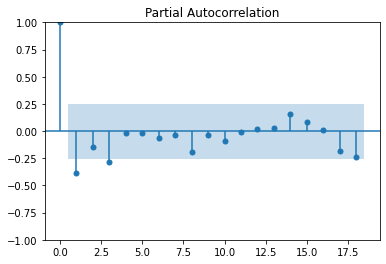

In [85]:
# ADF test to see stationarity
adf_test_new = adfuller(df_train_diff[['Location']])
# When p <= 0.05, then data is stationary
print(f'p-value: {adf_test_new[1]}')
# Compute autocorrelation
acf = plot_acf(df_train_diff[['Location']])

# Compute partial autocorrelation function
pacf = plot_pacf(df_train_diff[['Location']])

In [97]:
from statsmodels.tsa.arima.model import ARIMA
# fit model
model = ARIMA(df_train_diff['Location'], order=(0,0,1))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               Location   No. Observations:                   60
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -311.523
Date:                Mon, 22 May 2023   AIC                            629.045
Time:                        16:23:53   BIC                            635.328
Sample:                             0   HQIC                           631.503
                                 - 60                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.2464      2.583     -1.257      0.209      -8.310       1.817
ma.L1         -0.5622      0.111     -5.068      0.000      -0.780      -0.345
sigma2      1881.7923    344.547      5.462      0.0

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



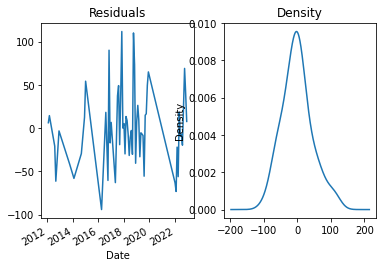

In [98]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

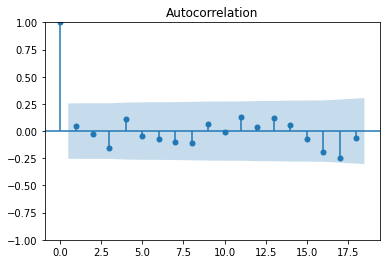

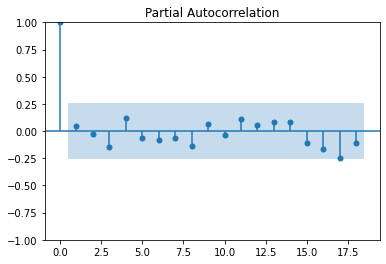

In [99]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



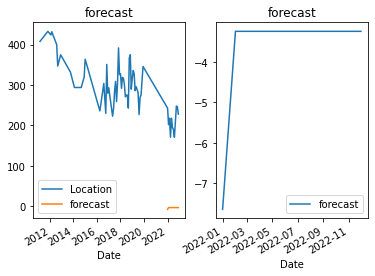

<Figure size 720x720 with 0 Axes>

In [100]:
forecast_test = model_fit.forecast(len(validation_grouped))
validation_grouped['forecast'] = list(forecast_test)

fig1, ax1 = plt.subplots(1,2)
training_grouped[['Location']].plot(title='Original', ax=ax1[0])
validation_grouped[['forecast']].plot(title='forecast', ax=ax1[0])
validation_grouped[['forecast']].plot(title='forecast', ax=ax1[1])
plt.figure(figsize=(10,10))
plt.show()

In [101]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

train, test = training_grouped['Crime ID'], validation_grouped['Crime ID']
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(0,0,1))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MSE: %.3f' % mse)

predicted=263.833481, expected=243.000000
predicted=269.722363, expected=202.000000
predicted=245.697917, expected=218.000000
predicted=264.182882, expected=171.000000
predicted=230.499298, expected=218.000000
predicted=269.098071, expected=195.000000
predicted=237.989872, expected=190.000000
predicted=249.357408, expected=171.000000
predicted=232.569376, expected=248.000000
predicted=278.436850, expected=246.000000
predicted=254.770512, expected=228.000000
Test RMSE: 52.715
Test MAE: 45.184
Test MSE: 2778.833


In [102]:
burglary_data_grouped = burglary_data.groupby(['Year', 'Month']).count()
burglary_data_grouped.reset_index(inplace=True)
fig_mult = px.line(burglary_data_grouped, x='Month', y='Location', color='Year',
                   title="Seasonal Plot: Burglary Cases Growth")
fig_mult.update_yaxes(title="Number of Cases")
fig_mult.update_traces(mode="markers+lines", hovertemplate=None)
fig_mult.update_layout(hovermode="x unified")

fig_mult.show()

In [103]:
import pmdarima as pm
auto_arima = pm.auto_arima(df_train_diff[['Location']], stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(0, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [104]:
auto_arima.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -312.254
Date:                Mon, 22 May 2023   AIC                            628.509
Time:                        16:24:24   BIC                            632.697
Sample:                             0   HQIC                           630.147
                                 - 60                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5109      0.115     -4.450      0.000      -0.736      -0.286
sigma2      1930.3091    363.016      5.317      0.000    1218.811    2641.807
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.57
Prob(Q):                              0.98   Prob(JB):                         0.46
Heteroskedasticity (H):               0.74   Skew:                             0.38
Prob(H) (two-sided):                  0.51   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



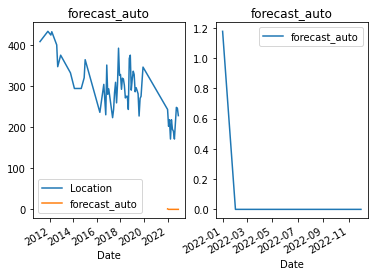

<Figure size 720x720 with 0 Axes>

In [106]:
forecast_test_auto = auto_arima.predict(len(validation_grouped))
validation_grouped['forecast_auto'] = list(forecast_test_auto)

fig2, ax2 = plt.subplots(1,2)
training_grouped[['Location']].plot(title='Original', ax=ax2[0])
validation_grouped[['forecast_auto']].plot(title='forecast_auto', ax=ax2[0])
validation_grouped[['forecast_auto']].plot(title='forecast_auto', ax=ax2[1])
plt.figure(figsize=(10,10))
plt.show()